In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel, get_linear_schedule_with_warmup
from torch.optim import AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder, StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [5]:
# Load your data
df = pd.read_csv('training_set_rel3.tsv', sep='\t', encoding='ISO-8859-1')
df = df.rename(columns={'essay_set': 'topic', 'domain1_score': 'score'})

# Create classification labels (0-10 scale to 0-10 classes)
df['label'] = df['score'].apply(lambda x: min(int(x/2), 10))  # Convert 0-20 scale to 0-10 classes

print(f"Dataset shape: {df.shape}")
print(f"Topics: {df['topic'].unique()}")
print(f"Label distribution:\n{df['label'].value_counts().sort_index()}")
print(f"\nSample essays:")
print(df[['essay', 'topic', 'score', 'label']].head(3))

Dataset shape: (12976, 29)
Topics: [1 2 3 4 5 6 7 8]
Label distribution:
label
0     2154
1     5275
2     1520
3      300
4     1120
5      537
6      215
7      191
8      359
9      206
10    1099
Name: count, dtype: int64

Sample essays:
                                               essay  topic  score  label
0  Dear local newspaper, I think effects computer...      1      8      4
1  Dear @CAPS1 @CAPS2, I believe that using compu...      1      9      4
2  Dear, @CAPS1 @CAPS2 @CAPS3 More and more peopl...      1      7      3


In [6]:
class EssayDataset(Dataset):
    def __init__(self, essays, topics, labels, tokenizer, max_len=512):
        self.essays = essays
        self.topics = topics
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.essays)

    def __getitem__(self, idx):
        essay = str(self.essays[idx])
        topic = self.topics[idx]
        label = self.labels[idx]

        # Tokenize essay
        encoding = self.tokenizer.encode_plus(
            essay,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'topic': torch.tensor(topic, dtype=torch.long),
            'labels': torch.tensor(label, dtype=torch.long)
        }

In [7]:
class BERTEssayClassifier(nn.Module):
    def __init__(self, num_classes=11, num_topics=8, dropout_rate=0.3):
        super(BERTEssayClassifier, self).__init__()

        # BERT base model
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.bert_drop = nn.Dropout(dropout_rate)

        # Topic embedding
        self.topic_embedding = nn.Embedding(num_topics, 768)  # 768 matches BERT hidden size

        # Topic-aware attention
        self.topic_attention = nn.MultiheadAttention(embed_dim=768, num_heads=8, dropout=dropout_rate)

        # Feature fusion
        self.fusion_layer = nn.Linear(768 * 2, 768)
        self.fusion_drop = nn.Dropout(dropout_rate)

        # Classification head
        self.classifier = nn.Sequential(
            nn.Linear(768, 384),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(384, 192),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(192, num_classes)
        )

    def forward(self, input_ids, attention_mask, topic):
        # BERT features
        bert_output = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        essay_features = bert_output.pooler_output  # [batch_size, 768]

        # Topic features
        topic_embed = self.topic_embedding(topic)  # [batch_size, 768]

        # Topic-aware attention
        essay_features_reshaped = essay_features.unsqueeze(0)  # [1, batch_size, 768]
        topic_embed_reshaped = topic_embed.unsqueeze(0)  # [1, batch_size, 768]

        attended_features, _ = self.topic_attention(
            query=essay_features_reshaped,
            key=topic_embed_reshaped,
            value=topic_embed_reshaped
        )
        attended_features = attended_features.squeeze(0)  # [batch_size, 768]

        # Feature fusion
        combined = torch.cat([essay_features, attended_features], dim=-1)  # [batch_size, 1536]
        fused = self.fusion_drop(torch.relu(self.fusion_layer(combined)))  # [batch_size, 768]

        # Classification
        logits = self.classifier(fused)

        return logits

In [8]:
# Initialize tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Split data
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['topic'])
train_df, val_df = train_test_split(train_df, test_size=0.1, random_state=42, stratify=train_df['topic'])

print(f"Train size: {len(train_df)}")
print(f"Validation size: {len(val_df)}")
print(f"Test size: {len(test_df)}")

# Create datasets
train_dataset = EssayDataset(
    essays=train_df['essay'].values,
    topics=train_df['topic'].values - 1,  # Convert to 0-indexed
    labels=train_df['label'].values,
    tokenizer=tokenizer
)

val_dataset = EssayDataset(
    essays=val_df['essay'].values,
    topics=val_df['topic'].values - 1,
    labels=val_df['label'].values,
    tokenizer=tokenizer
)

test_dataset = EssayDataset(
    essays=test_df['essay'].values,
    topics=test_df['topic'].values - 1,
    labels=test_df['label'].values,
    tokenizer=tokenizer
)

# Create data loaders
batch_size = 8
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Number of batches - Train: {len(train_loader)}, Val: {len(val_loader)}, Test: {len(test_loader)}")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Train size: 9342
Validation size: 1038
Test size: 2596
Number of batches - Train: 1168, Val: 130, Test: 325


In [9]:
# Initialize model
model = BERTEssayClassifier(num_classes=11, num_topics=8).to(device)

# Training parameters
epochs = 10
learning_rate = 2e-5
total_steps = len(train_loader) * epochs

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = AdamW(model.parameters(), lr=learning_rate)
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"Training for {epochs} epochs with learning rate {learning_rate}")

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Model parameters: 113,402,507
Training for 10 epochs with learning rate 2e-05


In [10]:
# ============================
# INITIALIZE MODEL
# ============================
print("="*60)
print("🚀 INITIALIZING BERT ESSAY CLASSIFIER")
print("="*60)

with tqdm(total=5, desc="Setup Progress") as pbar:
    # 1. Create model
    model = BERTEssayClassifier(num_classes=11, num_topics=8).to(device)
    pbar.update(1)
    pbar.set_description("Model created")

    # 2. Training parameters
    epochs = 10
    learning_rate = 2e-5
    total_steps = len(train_loader) * epochs
    pbar.update(1)
    pbar.set_description("Training params set")

    # 3. Loss functions (separate for topic and score)
    topic_criterion = nn.CrossEntropyLoss()
    score_criterion = nn.CrossEntropyLoss()
    pbar.update(1)
    pbar.set_description("Loss functions ready")

    # 4. Optimizer
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=0.01)
    pbar.update(1)
    pbar.set_description("Optimizer configured")

    # 5. Scheduler
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=0,
        num_training_steps=total_steps
    )
    pbar.update(1)
    pbar.set_description("Scheduler ready")

print("\n✅ SETUP COMPLETE!")
print("="*60)

# Display model info
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\n📊 MODEL INFORMATION:")
print(f"  • Device: {device}")
print(f"  • Total parameters: {total_params:,}")
print(f"  • Trainable parameters: {trainable_params:,}")
print(f"  • BERT source: Local folder ('bert-base-uncased')")
print(f"  • Topic classes: 8")
print(f"  • Score classes: 11 (0-10 scale)")

print(f"\n⚙️ TRAINING CONFIG:")
print(f"  • Epochs: {epochs}")
print(f"  • Learning rate: {learning_rate}")
print(f"  • Total steps: {total_steps:,}")
print(f"  • Batch size: {batch_size}")
print(f"  • Optimizer: AdamW (weight_decay=0.01)")
print(f"  • Scheduler: Linear with warmup")

🚀 INITIALIZING BERT ESSAY CLASSIFIER


Scheduler ready: 100%|██████████| 5/5 [00:02<00:00,  2.46it/s]


✅ SETUP COMPLETE!

📊 MODEL INFORMATION:
  • Device: cuda
  • Total parameters: 113,402,507
  • Trainable parameters: 113,402,507
  • BERT source: Local folder ('bert-base-uncased')
  • Topic classes: 8
  • Score classes: 11 (0-10 scale)

⚙️ TRAINING CONFIG:
  • Epochs: 10
  • Learning rate: 2e-05
  • Total steps: 11,680
  • Batch size: 8
  • Optimizer: AdamW (weight_decay=0.01)
  • Scheduler: Linear with warmup


In [11]:
def train_epoch(model, data_loader, criterion, optimizer, scheduler, device):
    model.train()
    total_loss = 0
    all_preds = []
    all_labels = []

    progress_bar = tqdm(data_loader, desc='Training')
    for batch in progress_bar:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        topics = batch['topic'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()

        outputs = model(input_ids, attention_mask, topics)
        loss = criterion(outputs, labels)

        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()

        total_loss += loss.item()

        # Get predictions
        _, preds = torch.max(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        # Update progress bar
        progress_bar.set_postfix({'loss': loss.item()})

    avg_loss = total_loss / len(data_loader)
    accuracy = accuracy_score(all_labels, all_preds)

    return avg_loss, accuracy

def eval_epoch(model, data_loader, criterion, device):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for batch in tqdm(data_loader, desc='Evaluating'):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            topics = batch['topic'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask, topics)
            loss = criterion(outputs, labels)

            total_loss += loss.item()

            # Get predictions and probabilities
            _, preds = torch.max(outputs, dim=1)
            probs = torch.softmax(outputs, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    avg_loss = total_loss / len(data_loader)

    return avg_loss, all_preds, all_labels, all_probs

In [12]:
# Store training history
history = {
    'train_loss': [], 'train_acc': [],
    'val_loss': [], 'val_acc': []
}

best_val_acc = 0
best_model_state = None

print("Starting training...")
print("="*60)

for epoch in range(epochs):
    print(f"\nEpoch {epoch+1}/{epochs}")
    print("-"*60)

    # Training
    train_loss, train_acc = train_epoch(
        model, train_loader, criterion, optimizer, scheduler, device
    )

    # Validation
    val_loss, val_preds, val_labels, val_probs = eval_epoch(
        model, val_loader, criterion, device
    )
    val_acc = accuracy_score(val_labels, val_preds)

    # Store history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_state = model.state_dict().copy()
        torch.save(best_model_state, 'best_bert_essay_classifier.pth')
        print(f"✅ New best model saved with Val Acc: {val_acc:.4f}")

# Load best model
model.load_state_dict(torch.load('best_bert_essay_classifier.pth'))
print(f"\n✅ Training completed. Best validation accuracy: {best_val_acc:.4f}")

Starting training...

Epoch 1/10
------------------------------------------------------------


Evaluating: 100%|██████████| 130/130 [00:31<00:00,  4.07it/s]


Train Loss: 1.1441, Train Acc: 0.6033
Val Loss: 0.7515, Val Acc: 0.7245
✅ New best model saved with Val Acc: 0.7245

Epoch 2/10
------------------------------------------------------------


Evaluating: 100%|██████████| 130/130 [00:31<00:00,  4.10it/s]


Train Loss: 0.7267, Train Acc: 0.7268
Val Loss: 0.6553, Val Acc: 0.7428
✅ New best model saved with Val Acc: 0.7428

Epoch 3/10
------------------------------------------------------------


Evaluating: 100%|██████████| 130/130 [00:31<00:00,  4.07it/s]


Train Loss: 0.6091, Train Acc: 0.7790
Val Loss: 0.6692, Val Acc: 0.7553
✅ New best model saved with Val Acc: 0.7553

Epoch 4/10
------------------------------------------------------------


Evaluating: 100%|██████████| 130/130 [00:31<00:00,  4.08it/s]


Train Loss: 0.5135, Train Acc: 0.8304
Val Loss: 0.7682, Val Acc: 0.7563
✅ New best model saved with Val Acc: 0.7563

Epoch 5/10
------------------------------------------------------------


Evaluating: 100%|██████████| 130/130 [00:31<00:00,  4.07it/s]


Train Loss: 0.4348, Train Acc: 0.8637
Val Loss: 0.9252, Val Acc: 0.7649
✅ New best model saved with Val Acc: 0.7649

Epoch 6/10
------------------------------------------------------------


Training:   3%|▎         | 34/1168 [00:27<15:04,  1.25it/s, loss=0.0128]


KeyboardInterrupt: 

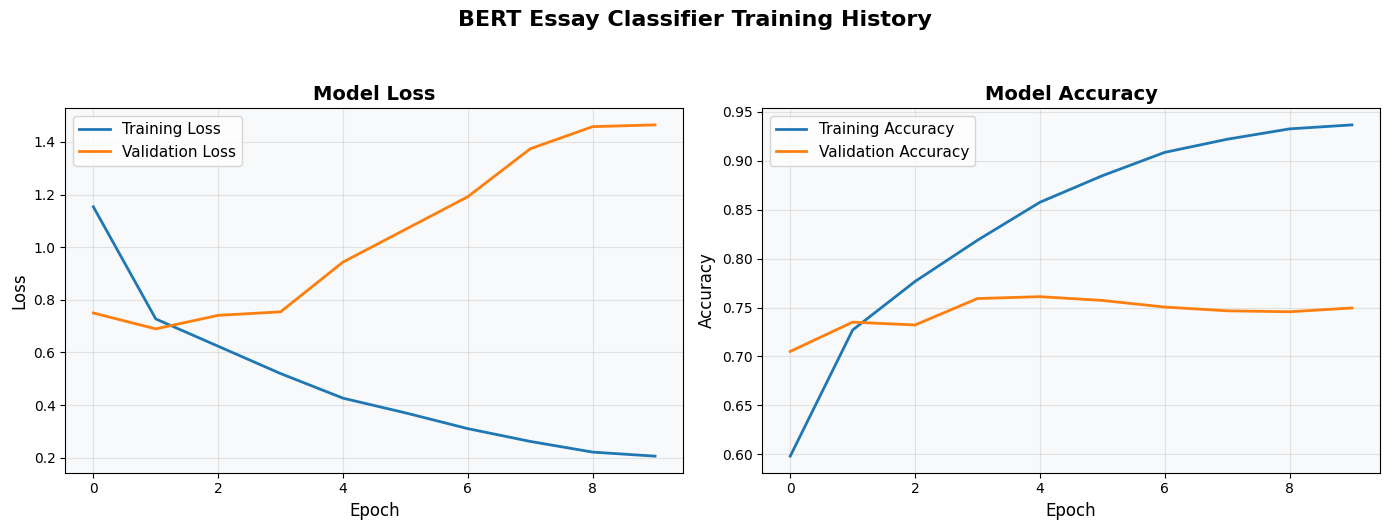

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss plot
axes[0].plot(history['train_loss'], label='Training Loss', linewidth=2)
axes[0].plot(history['val_loss'], label='Validation Loss', linewidth=2)
axes[0].set_title('Model Loss', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)
axes[0].set_facecolor('#f8f9fa')

# Accuracy plot
axes[1].plot(history['train_acc'], label='Training Accuracy', linewidth=2)
axes[1].plot(history['val_acc'], label='Validation Accuracy', linewidth=2)
axes[1].set_title('Model Accuracy', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Accuracy', fontsize=12)
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)
axes[1].set_facecolor('#f8f9fa')

plt.suptitle('BERT Essay Classifier Training History', fontsize=16, fontweight='bold', y=1.05)
plt.tight_layout()
plt.show()

In [13]:
from google.colab import files

files.download('best_bert_essay_classifier_updated.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
def evaluate_model(model, data_loader, device):
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for batch in tqdm(data_loader, desc='Testing'):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            topics = batch['topic'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask, topics)
            probs = torch.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    return all_preds, all_labels, all_probs

# Get test predictions
test_preds, test_labels, test_probs = evaluate_model(model, test_loader, device)

print("Test Set Evaluation:")
print("="*60)

Testing: 100%|██████████| 325/325 [01:30<00:00,  3.60it/s]

Test Set Evaluation:


📊 COMPREHENSIVE EVALUATION METRICS
Accuracy: 0.7504
Precision (macro): 0.5264
Recall (macro): 0.5451
F1-Score (macro): 0.5259
AUC-ROC (macro): 0.9645
Exact Match (EM): 0.7504
Top-3 Accuracy: 0.9734


📋 CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0       0.80      0.80      0.80       445
           1       0.84      0.84      0.84      1040
           2       0.74      0.70      0.72       305
           3       0.45      0.56      0.50        52
           4       0.67      0.68      0.68       219
           5       0.56      0.54      0.55       113
           6       0.28      0.10      0.15        50
           7       0.22      0.14      0.17        42
           8       0.38      0.71      0.50        76
           9       0.00      0.00      0.00        38
          10       0.85      0.92      0.88       216

    accuracy                           0.75      2596
   macro avg       0.53      0.55      0.53      2596
weighted avg      

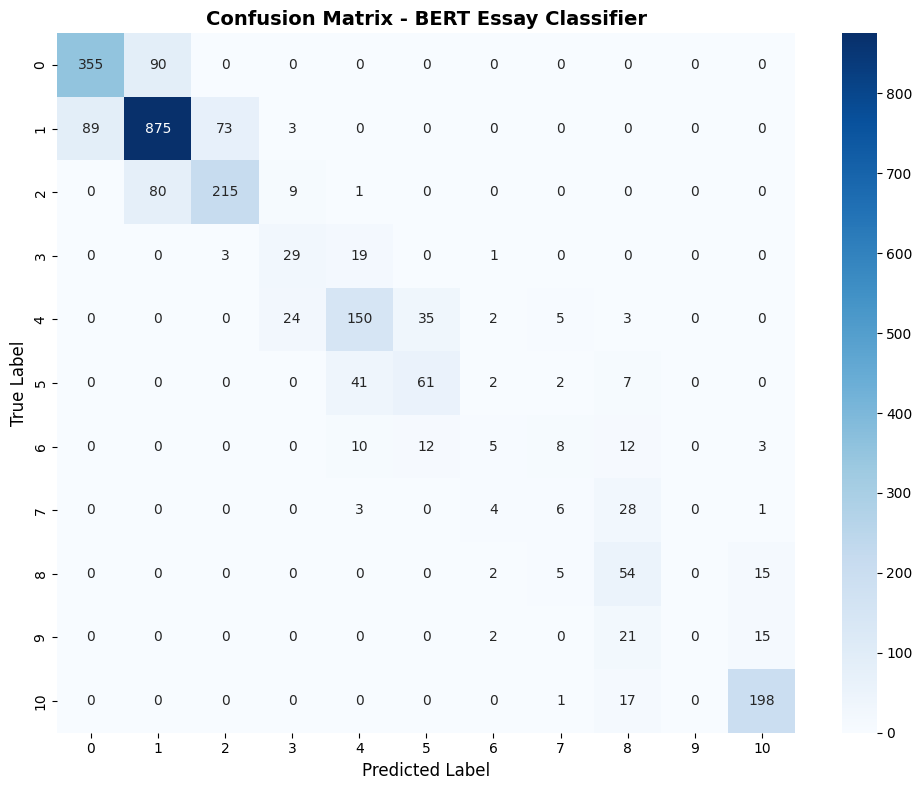

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import numpy as np

# 1. Accuracy
accuracy = accuracy_score(test_labels, test_preds)

# 2. Precision, Recall, F1-Score (macro average)
precision = precision_score(test_labels, test_preds, average='macro', zero_division=0)
recall = recall_score(test_labels, test_preds, average='macro', zero_division=0)
f1 = f1_score(test_labels, test_preds, average='macro', zero_division=0)

# 3. AUC (One-vs-Rest)
try:
    auc = roc_auc_score(test_labels, test_probs, multi_class='ovr', average='macro')
except:
    auc = 0.0

# 4. Exact Match (EM) - Exact match ratio
em = accuracy_score(test_labels, test_preds)  # Same as accuracy for classification

# 5. Top-k Accuracy (k=3)
def top_k_accuracy(y_true, y_prob, k=3):
    top_k_preds = np.argsort(y_prob, axis=1)[:, -k:]
    correct = 0
    for i, true_label in enumerate(y_true):
        if true_label in top_k_preds[i]:
            correct += 1
    return correct / len(y_true)

top_3_acc = top_k_accuracy(test_labels, test_probs, k=3)

# 6. Confusion Matrix
cm = confusion_matrix(test_labels, test_preds)

# Print all metrics
print("📊 COMPREHENSIVE EVALUATION METRICS")
print("="*60)
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision (macro): {precision:.4f}")
print(f"Recall (macro): {recall:.4f}")
print(f"F1-Score (macro): {f1:.4f}")
print(f"AUC-ROC (macro): {auc:.4f}")
print(f"Exact Match (EM): {em:.4f}")
print(f"Top-3 Accuracy: {top_3_acc:.4f}")
print("\n" + "="*60)

# Classification Report
print("\n📋 CLASSIFICATION REPORT")
print("="*60)
print(classification_report(test_labels, test_preds, zero_division=0))

# Confusion Matrix Plot
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=range(11), yticklabels=range(11))
plt.title('Confusion Matrix - BERT Essay Classifier', fontsize=14, fontweight='bold')
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.tight_layout()
plt.show()

📊 TOPIC-WISE PERFORMANCE
 topic  samples  accuracy  f1_score
     1      357  0.644258  0.313854
     2      360  0.786111  0.520760
     3      345  0.788406  0.779853
     4      354  0.870056  0.867623
     5      361  0.808864  0.716607
     6      360  0.805556  0.766589
     7      314  0.407643  0.205791
     8      145  1.000000  1.000000


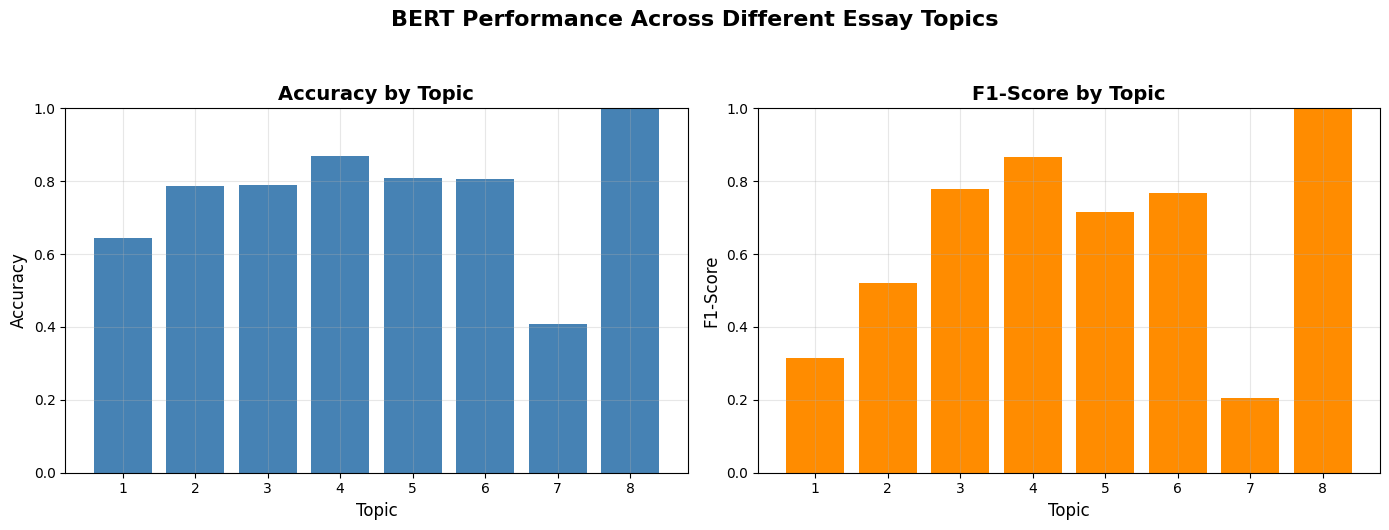

In [ ]:
# Add predictions to test dataframe
test_df = test_df.copy()
test_df['pred'] = test_preds
test_df['prob_max'] = [max(probs) for probs in test_probs]

# Topic-wise performance
topic_results = []
for topic in range(1, 9):
    topic_df = test_df[test_df['topic'] == topic]
    if len(topic_df) > 0:
        topic_acc = accuracy_score(topic_df['label'], topic_df['pred'])
        topic_f1 = f1_score(topic_df['label'], topic_df['pred'], average='macro', zero_division=0)
        topic_results.append({
            'topic': topic,
            'samples': len(topic_df),
            'accuracy': topic_acc,
            'f1_score': topic_f1
        })

topic_results_df = pd.DataFrame(topic_results)

print("📊 TOPIC-WISE PERFORMANCE")
print("="*60)
print(topic_results_df.to_string(index=False))

# Plot topic performance
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy by topic
axes[0].bar(topic_results_df['topic'], topic_results_df['accuracy'], color='steelblue')
axes[0].set_title('Accuracy by Topic', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Topic', fontsize=12)
axes[0].set_ylabel('Accuracy', fontsize=12)
axes[0].set_ylim(0, 1)
axes[0].grid(True, alpha=0.3)

# F1-Score by topic
axes[1].bar(topic_results_df['topic'], topic_results_df['f1_score'], color='darkorange')
axes[1].set_title('F1-Score by Topic', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Topic', fontsize=12)
axes[1].set_ylabel('F1-Score', fontsize=12)
axes[1].set_ylim(0, 1)
axes[1].grid(True, alpha=0.3)

plt.suptitle('BERT Performance Across Different Essay Topics', fontsize=16, fontweight='bold', y=1.05)
plt.tight_layout()
plt.show()

In [ ]:
class EssayScorer:
    def __init__(self, model_path='best_bert_essay_classifier.pth'):
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

        # Load model
        self.model = BERTEssayClassifier(num_classes=11, num_topics=8).to(self.device)
        self.model.load_state_dict(torch.load(model_path, map_location=self.device))
        self.model.eval()

        self.topic_names = {
            1: 'computers', 2: 'censorship', 3: 'cyclist',
            4: 'hibiscus', 5: 'mood', 6: 'dirigibles',
            7: 'patience', 8: 'laughter'
        }

        print("✅ BERT Essay Scorer loaded!")

    def predict(self, essay_text, topic_number):
        """Predict score for a single essay"""
        if topic_number not in range(1, 9):
            raise ValueError(f"Topic must be 1-8, got {topic_number}")

        # Tokenize
        encoding = self.tokenizer.encode_plus(
            essay_text,
            add_special_tokens=True,
            max_length=512,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        # Prepare inputs
        input_ids = encoding['input_ids'].to(self.device)
        attention_mask = encoding['attention_mask'].to(self.device)
        topic = torch.tensor([topic_number - 1], dtype=torch.long).to(self.device)

        # Predict - Handle different model outputs
        with torch.no_grad():
            outputs = self.model(input_ids, attention_mask, topic)

            # Check what the model returns
            print(f"Model output type: {type(outputs)}")
            if isinstance(outputs, tuple):
                print(f"Number of outputs: {len(outputs)}")
                for i, out in enumerate(outputs):
                    print(f"Output {i} shape: {out.shape if hasattr(out, 'shape') else 'N/A'}")

            # Try different unpacking strategies
            try:
                # If model returns tuple (topic_logits, score_logits)
                if isinstance(outputs, tuple) and len(outputs) == 2:
                    topic_logits, score_logits = outputs
                # If model returns only score_logits
                else:
                    score_logits = outputs if not isinstance(outputs, tuple) else outputs[0]

                probs = torch.softmax(score_logits, dim=1)
                pred_class = torch.argmax(score_logits, dim=1).item()
                confidence = probs[0, pred_class].item()

            except Exception as e:
                print(f"Error processing model output: {e}")
                # Try direct approach
                if hasattr(outputs, 'shape'):
                    score_logits = outputs
                    probs = torch.softmax(score_logits, dim=1)
                    pred_class = torch.argmax(score_logits, dim=1).item()
                    confidence = probs[0, pred_class].item()
                else:
                    raise

        # The score seems to be on a 0-10 scale based on your output
        score = pred_class*2

        return {
            'score': score,
            'class': pred_class,
            'confidence': confidence,
            'topic': f"{topic_number} - {self.topic_names[topic_number]}",
            'probabilities': probs.cpu().numpy()[0] if hasattr(probs, 'cpu') else probs
        }

# Initialize scorer
scorer = EssayScorer()

# Test prediction
sample_essay = """Computers and other devices are good for humans especially young people like myself because they are good for communication, keeping the attention of the and providing unknown information. In @CAPS3 letter, I will explain. Communication is key, and technology is close the best and fastest way to use communiocation. Cell phones provide calling usage of course, but they also allow you to text someone. If you have dinner with friends and your late, with text you can send them a message and they should get it in no time at all. Email allows you to do the same as text, but you can write longer messages. Something that's really good for communicating is video chat. If you have a relative that you haven't seen in a long time you can video chat and they can see you and you can see them. It's like talking to one another in person. Keeping a persons attention is critical. Technology does that with games, music from @NUM1's, computers, game systems and the newest way, iPod's and instructions on how to do something. Of course a teacher or parents can do that, but heaving or seeing instructions on a computer is so much more exciting, which brings me back to @CAPS3 topic of keeping a persons attention. Technological devices are more exciting than people teachers and definitely parents but do they offer more? Information is most likiely the most frequent reason in which technology is used. If a child has a project for school, they either use the computers or asks their parents. If the parents have no idea about the question their child just asked, they say, "@CAPS1 it up on the computer", if you havent already done that. So in a way the human race depends on technology, actually we do depend on technology. Computers cellphones, iPods, gamesystems, etc all include a little thing I'd like to call the internet. The internet has been around for a while, going from extremely slow to high-speed, and it is a magical place. It can provide you with directions,recipes, job offers, store locations show times for movies and much , much more. Although technology is used in everyday life from communication to searching for information it can slowly us the human race down. I mean most of us spend most of our time on @CAPS2 or @CAPS3 @CAPS4 when we should be walking around are exercising, looking at the trees and the birds and communicating with family face ti face. Therefore, computers and other things are nice and all, but are the worth getting fat or loosing touch with your loved ones."""
sample_topic = 1

result = scorer.predict(sample_essay, sample_topic)
print("\n🧪 SAMPLE PREDICTION")
print("="*60)
print(f"Essay: '{sample_essay[:60]}...'")
print(f"Topic: {result['topic']}")
print(f"Predicted Score: {result['score']}/10")
print(f"Confidence: {result['confidence']:.3f}")

# Test prediction
sample_essay = """Computers and other devices are good for humans especially young people like myself because they are good for communication, keeping the attention of the and providing unknown information. In @CAPS3 letter, I will explain. Communication is key, and technology is close the best and fastest way to use communiocation. Cell phones provide calling usage of course, but they also allow you to text someone. If you have dinner with friends and your late, with text you can send them a message and they should get it in no time at all. Email allows you to do the same as text, but you can write longer messages. Something that's really good for communicating is video chat. If you have a relative that you haven't seen in a long time you can video chat and they can see you and you can see them. It's like talking to one another in person. Keeping a persons attention is critical. Technology does that with games, music from @NUM1's, computers, game systems and the newest way, iPod's and instructions on how to do something. Of course a teacher or parents can do that, but heaving or seeing instructions on a computer is so much more exciting, which brings me back to @CAPS3 topic of keeping a persons attention. Technological devices are more exciting than people teachers and definitely parents but do they offer more? Information is most likiely the most frequent reason in which technology is used. If a child has a project for school, they either use the computers or asks their parents. If the parents have no idea about the question their child just asked, they say, "@CAPS1 it up on the computer", if you havent already done that. So in a way the human race depends on technology, actually we do depend on technology. Computers cellphones, iPods, gamesystems, etc all include a little thing I'd like to call the internet. The internet has been around for a while, going from extremely slow to high-speed, and it is a magical place. It can provide you with directions,recipes, job offers, store locations show times for movies and much , much more. Although technology is used in everyday life from communication to searching for information it can slowly us the human race down. I mean most of us spend most of our time on @CAPS2 or @CAPS3 @CAPS4 when we should be walking around are exercising, looking at the trees and the birds and communicating with family face ti face. Therefore, computers and other things are nice and all, but are the worth getting fat or loosing touch with your loved ones."""
sample_topic = 4

result = scorer.predict(sample_essay, sample_topic)
print("\n🧪 SAMPLE PREDICTION")
print("="*60)
print(f"Essay: '{sample_essay[:60]}...'")
print(f"Topic: {result['topic']}")
print(f"Predicted Score: {result['score']}/10")
print(f"Confidence: {result['confidence']:.3f}")

✅ BERT Essay Scorer loaded!
Model output type: <class 'torch.Tensor'>

🧪 SAMPLE PREDICTION
Essay: 'Computers and other devices are good for humans especially y...'
Topic: 1 - computers
Predicted Score: 10/10
Confidence: 0.810
Model output type: <class 'torch.Tensor'>

🧪 SAMPLE PREDICTION
Essay: 'Computers and other devices are good for humans especially y...'
Topic: 4 - hibiscus
Predicted Score: 2/10
Confidence: 0.492
